**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [19]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from datetime import datetime 

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D
from augmend import Augmend, Elastic, Identity, FlipRot90, AdditiveNoise, CutOut, Scale, GaussianBlur, Rotate, IntensityScaleShift, Choice, Rotate, DropEdgePlanes


np.random.seed(42)
lbl_cmap = random_label_cmap()
print(gputools_available())

True


In [24]:
root = '.'

augment = 2

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [30]:
X = sorted(glob(f'{root}/data/images/*.tif'))
Y = sorted(glob(f'{root}/data/masks/*.tif'))
print(X[1])

assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
print(X)
print(Y)
import json

json_files = sorted(glob(f'{root}/data/labels/*.json'))
print(json_files)

./data/images/fish2_nasal_20-80z.tif
['./data/images/fish2_nasal_15-75z.tif', './data/images/fish2_nasal_20-80z.tif', './data/images/fish2_nasal_25-85z.tif', './data/images/fish2_temporal_10-70z.tif', './data/images/fish2_temporal_20-81z.tif', './data/images/fish2_temporal_5-65z.tif']
['./data/masks/fish2_nasal_15-75z.tif', './data/masks/fish2_nasal_20-80z.tif', './data/masks/fish2_nasal_25-85z.tif', './data/masks/fish2_temporal_10-70z.tif', './data/masks/fish2_temporal_20-81z.tif', './data/masks/fish2_temporal_5-65z.tif']
['./data/labels/fish2_nasal_15-75z_corrected.json', './data/labels/fish2_nasal_20-80z.json', './data/labels/fish2_nasal_25-85z.json', './data/labels/fish2_temporal_10-70z.json', './data/labels/fish2_temporal_20-81z.json', './data/labels/fish2_temporal_5-65z_corrected.json']


In [31]:
X = list(map(imread,X))
X = [x[:, 0, :, :] for x in X]

Y = list(map(imread,Y))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]


Normalize images and fill small label holes.

In [32]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y).astype(np.uint16) for y in tqdm(Y)]



100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Split into train and validation datasets.

In [33]:
print(type(Y[0][0][0]))

<class 'numpy.ndarray'>


In [34]:
# if you want to use 2 channels, swap the channel position
#X = [np.moveaxis(x, 1, -1) for x in X]

In [35]:
# upload json files

C = []
for el in json_files:
    print(el)
    with open(el, 'r') as fp:
        class_dict = json.load(fp)
        C.append({int(k):int(v) for k,v in class_dict.items() if int(k) > 0})


classes = set()
for c in C:
    for k, item in c.items():
        classes.add(item)
print( classes)
n_classes = len(classes) 
print(n_classes)

./data/labels/fish2_nasal_15-75z_corrected.json
./data/labels/fish2_nasal_20-80z.json
./data/labels/fish2_nasal_25-85z.json
./data/labels/fish2_temporal_10-70z.json
./data/labels/fish2_temporal_20-81z.json
./data/labels/fish2_temporal_5-65z_corrected.json
{1, 2, 3, 4, 5, 6, 7, 8}
8


In [36]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val], [C[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train], [C[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

for j in range(len(Y)):
    print(len(np.unique(Y[j]))-1, len(list(C[j].keys())))


for j in range(len(Y_trn)):
    print(len(np.unique(Y_trn[j]))-1, len(list(C_trn[j].keys())))
   # print(np.unique(Y_trn[j]))
    #print(list(C_trn[j].keys()))

number of images:   6
- training:         5
- validation:       1
159 159
224 224
276 276
297 297
168 168
148 148
159 159
224 224
148 148
276 276
168 168


Training data consists of pairs of input image and label instances.

In [37]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

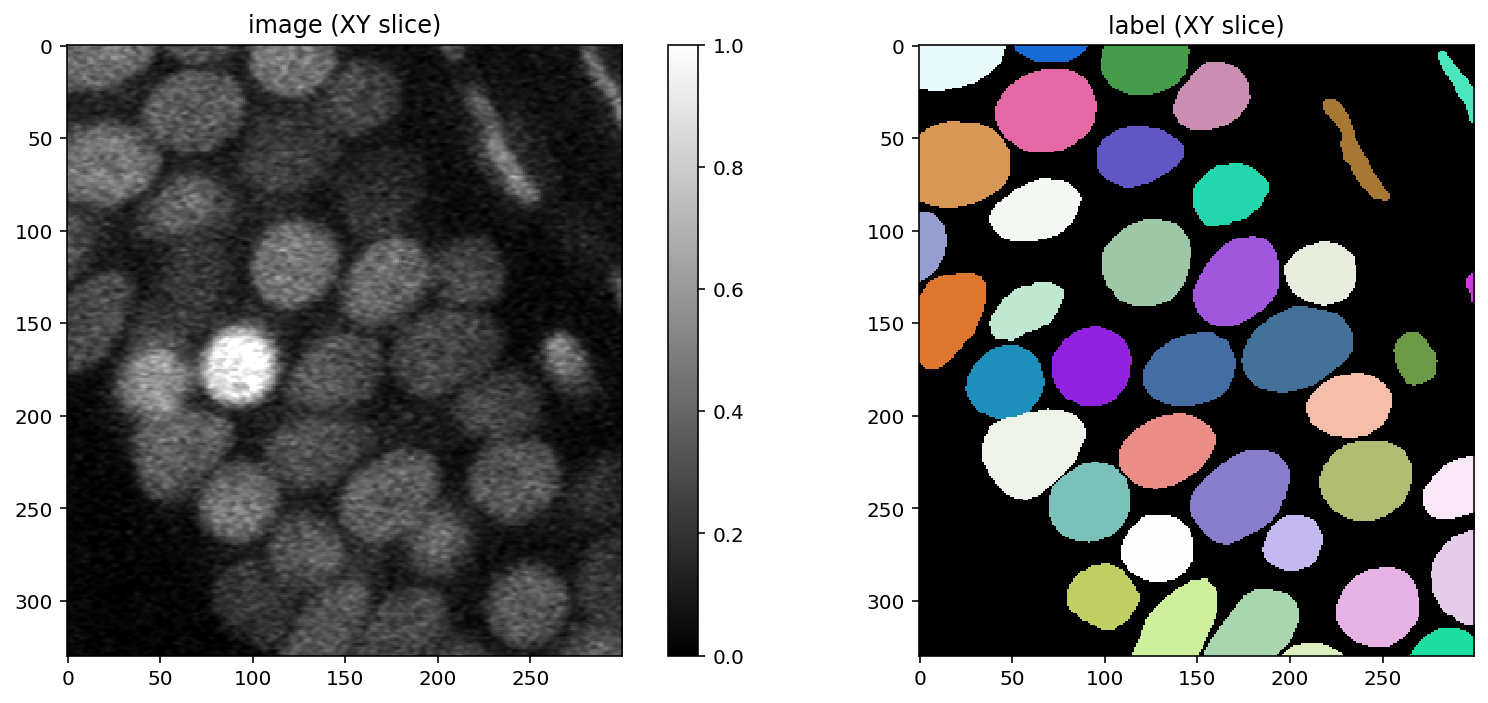

In [38]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [39]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
  

In [40]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))
print(extents)

empirical anisotropy of labeled objects = (3.0, 1.0112359550561798, 1.0)
[15.  44.5 45. ]


In [47]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 100

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)
print(grid)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    n_classes = n_classes,
    unet_n_depth     = 3,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (32,128,128),
    train_batch_size = 1,
    unet_pool = (4, 4, 4)
)
print(conf)
vars(conf)

(1, 2, 2)
Config3D(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=101, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=100, grid=(1, 2, 2), anisotropy=(3.0, 1.0112359550561798, 1.0), backbone='unet', rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 100, 'anisotropy': (3.0, 1.0112359550561798, 1.0)}}, n_classes=8, unet_n_depth=3, unet_kernel_size=(3, 3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(4, 4, 4), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), train_patch_size=(32, 128, 128), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1, 1, 1, 1, 1, 1, 1, 1), train_epochs=400, train_steps_per_epoch=100, train_le

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 101,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 100,
 'grid': (1, 2, 2),
 'anisotropy': (3.0, 1.0112359550561798, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 100, 'anisotropy': (3.0, 1.0112359550561798, 1.0)}},
 'n_classes': 8,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (4, 4, 4),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (32, 128, 128),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 

In [48]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8, total_memory=10000)
    print("use gpu")
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

use gpu


**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [49]:
timestamp = datetime.now().strftime("%d-%H:%M:%S")

model = StarDist3D(conf, name=f'{timestamp}_aug_{augment}', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [50]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2022-01-19 18:39:40.691329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


median object size:      [15.  44.5 45. ]
network field of view :  [32 64 64]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [45]:

aug = Augmend()

if augment==1:
    aug.add([FlipRot90(axis=(1,2)),FlipRot90(axis=(1,2))])
    aug.add([IntensityScaleShift(scale=(.5,2), shift=(-.2,.2)),Identity()])
elif augment==2:
    aug.add([FlipRot90(axis=(1,2)),FlipRot90(axis=(1,2))])
    aug.add([Elastic(grid=5, amount=5, order=0, axis=(1,2), use_gpu=use_gpu),
             Elastic(grid=5, amount=5, order=0, axis=(1,2), use_gpu=use_gpu)], probability=.6)
    aug.add([Scale(amount=(.7,1.3),mode="constant", use_gpu=use_gpu),
             Scale(amount=(.7,1.3),mode="constant", use_gpu=use_gpu, order=0)], probability=.4)
    aug.add([AdditiveNoise(sigma=(0,.03)),Identity()], probability=.5)
    aug.add([IntensityScaleShift(scale=(.5,2), shift=(-.2,.2)),Identity()])



def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = aug([x,y])
    return x,y


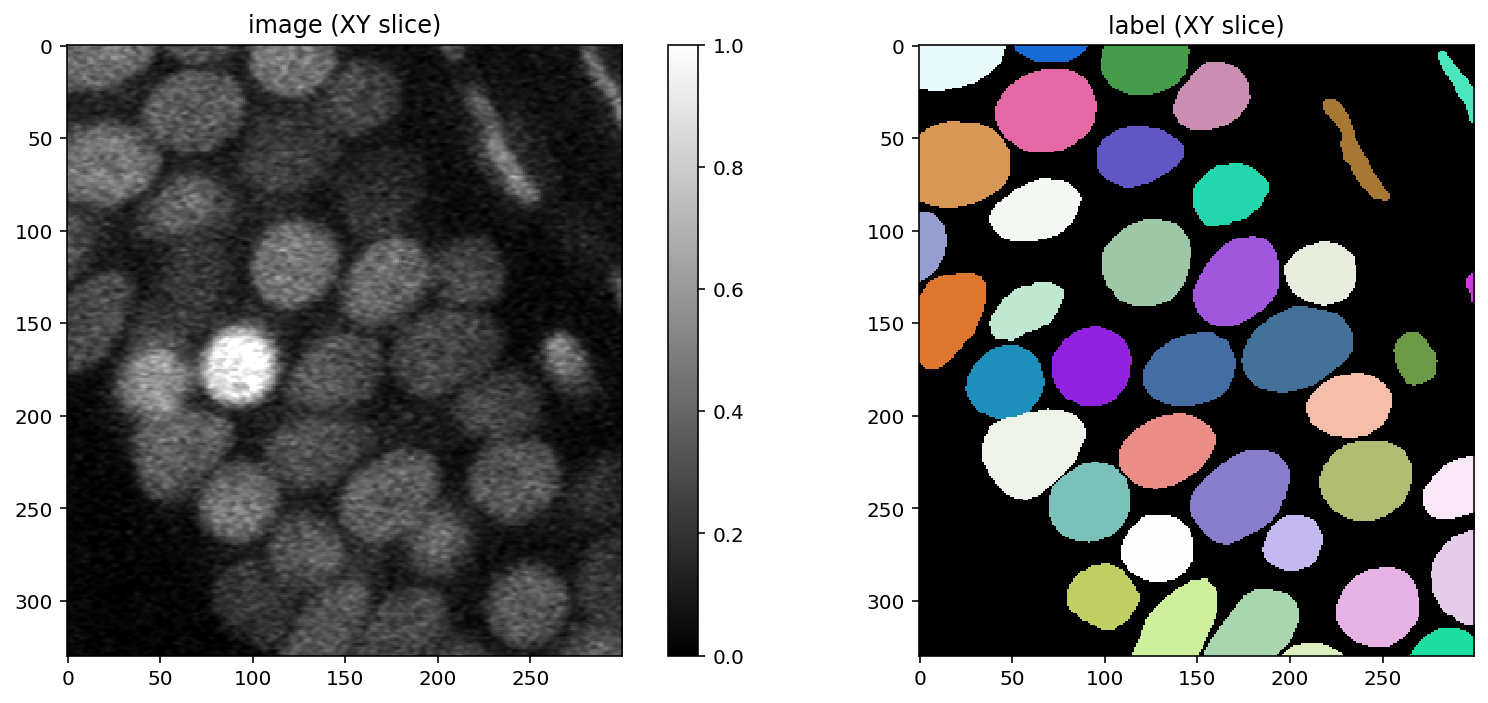

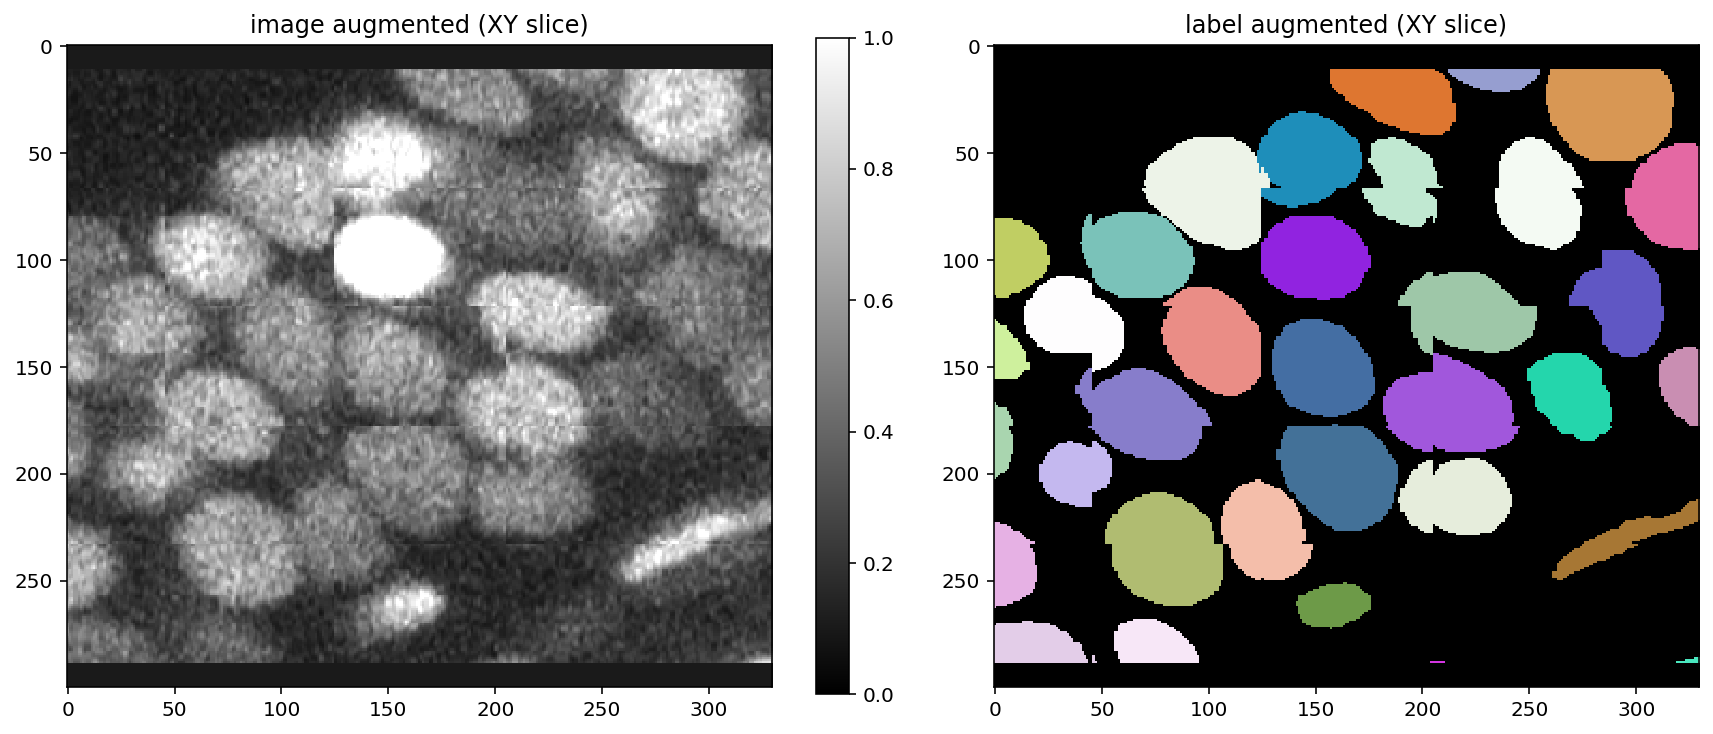

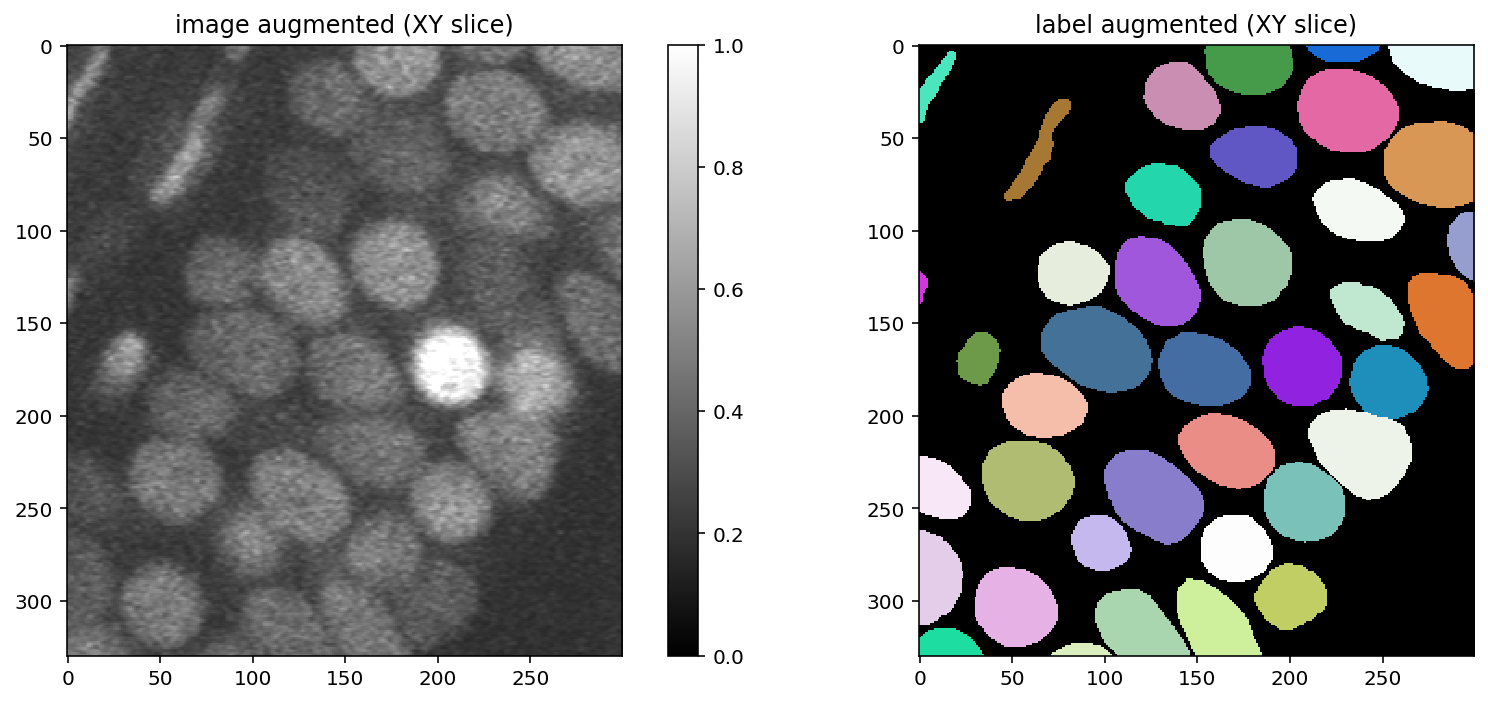

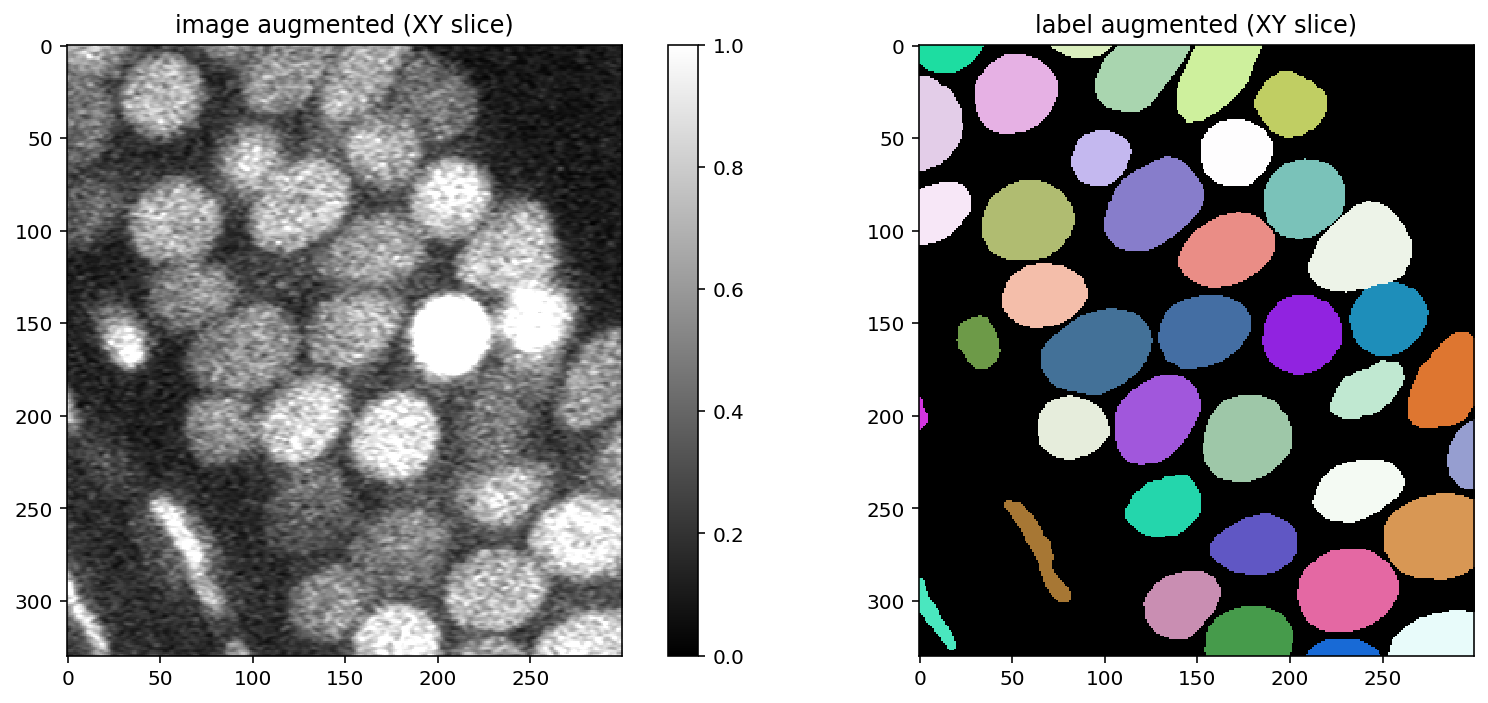

In [46]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

In [ ]:
#Y_trn = list(map(str, Y_trn))
#Y_val = list(map(str, Y_val))

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [ ]:
model.train(X_trn, Y_trn, classes = C_trn, validation_data=(X_val,Y_val, C_val), augmenter=augmenter, epochs=200)
None;

In [ ]:
for i in range(len(Y)):
    print('image', len(np.unique(Y[i])))
    print('dict', len(C[i]))


    

In [ ]:
a = sorted(np.unique(Y[2]))[1:]
b = list(C[2].keys())

for i in range(len(a)):
    if a[i] != b[i]:
        print(a[i], b[i], type(a[i]), type(b[i]) )

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [ ]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [ ]:
# help(matching)

First predict the labels for all validation images:

In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

Plot a GT/prediction example  

In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

Example: Print all available matching statistics for $\tau=0.7$

In [ ]:
stats[taus.index(0.7)]

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();